Jadr Health Insights data

Predicting asthma emergency room incidence rate based on air quality.


In [11]:
# Imports
import pymssql
import pandas as pd
import numpy as np
from config import database
from config import username
from config import password
from config import server
from config import asthma_table
from config import aq_table
from config import census_table
from config import county_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.impute import SimpleImputer



## Load the a data from the SQL database
Join the county and air quality tables to the asthma table. Select all years except 2021 (no asthma data is available that year.)

In [12]:
conn = pymssql.connect(server, username, password, database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    INNER JOIN {county_table} ON {asthma_table}.COUNTY_ID = {county_table}.COUNTY_ID
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query, conn)
print(len(df))
df.head(10)



247


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ASTHMA_ID,COUNTY_ID,YEAR,NUM_ED_VISITS,AGE_ADJ_ED_VISITS,AQ_ID,AQ_ID,COUNTY_ID,YEAR,LEAD_MEAN,...,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,SO2_METHOD_ID,SO2_METRIC_ID,SO2_UNITS_ID,COUNTY_ID,COUNTY_NAME,STATE_ID
0,220,862,2018,1770,38.0,767,767,862,2018,NaN,...,NaN,NaN,NaN,NaN,3,2,2,862,Sonoma,15
1,49,809,2015,3281,60.7,768,768,809,2015,NaN,...,NaN,NaN,NaN,NaN,3,2,2,809,Stanislaus,15
2,119,65,2017,198,55.1,769,769,65,2017,NaN,...,NaN,NaN,NaN,NaN,3,2,2,65,Calaveras,15
3,236,46,2019,5910,54.2,770,770,46,2019,NaN,...,NaN,NaN,NaN,NaN,3,2,2,46,Contra Costa,15
4,74,603,2016,487,79.4,771,771,603,2016,NaN,...,NaN,NaN,NaN,NaN,3,2,2,603,Lake,15
5,100,1737,2016,5534,29.1,772,772,1737,2016,NaN,...,1.800000,1.60,0.381402,1.70,3,2,2,1737,Santa Clara,15
6,19,3118,2015,52227,53.1,773,773,3118,2015,0.012374,...,21.666667,8.30,1.838851,9.70,3,2,2,3118,Los Angeles,15
7,94,2343,2016,10068,30.9,774,774,2343,2016,NaN,...,1.200000,0.65,0.154843,0.65,3,2,2,2343,San Diego,15
8,147,586,2017,10076,43.2,775,775,586,2017,0.005121,...,2.500000,1.90,0.414118,2.30,3,2,2,586,Riverside,15
9,87,2491,2016,8878,29.2,776,776,2491,2016,NaN,...,3.300000,2.10,0.496436,3.20,3,2,2,2491,Orange,15


In [13]:
# Exploratory
df.drop(['ASTHMA_ID', "NUM_ED_VISITS", "AQ_ID", "STATE_ID"],
        axis=1, inplace=True, errors="ignore") 
params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COUNTY_ID          247 non-null    int64  
 1   YEAR               247 non-null    int64  
 2   AGE_ADJ_ED_VISITS  247 non-null    float64
 3   COUNTY_ID          247 non-null    int64  
 4   YEAR               247 non-null    int64  
 5   LEAD_MEAN          17 non-null     float64
 6   LEAD_1STMAX        17 non-null     float64
 7   LEAD_99PERC        17 non-null     float64
 8   LEAD_STD           17 non-null     float64
 9   LEAD_2NDMAX        17 non-null     float64
 10  NO2_MEAN           163 non-null    float64
 11  NO2_1STMAX         163 non-null    float64
 12  NO2_99PERC         163 non-null    float64
 13  NO2_STD            163 non-null    float64
 14  NO2_2NDMAX         163 non-null    float64
 15  OZONE_MEAN         240 non-null    float64
 16  OZONE_1STMAX       240 non

### Remove the Method, Metric, and Units columns because we won't need them. Remove the lead and PM10 columns because they have so few measurements.

In [14]:
### Clean it
# Drop unnecessary columns

params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

# Remove lead and PM10 columns because they have so few measurements
params = ["LEAD", "PM10"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")


df[:]



,COUNTY_ID,YEAR,AGE_ADJ_ED_VISITS,COUNTY_ID,YEAR,NO2_MEAN,NO2_1STMAX,NO2_99PERC,NO2_STD,NO2_2NDMAX,...,PM25_99PERC,PM25_STD,PM25_2NDMAX,SO2_MEAN,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,COUNTY_ID,COUNTY_NAME
0,862,2018,38.0,862,2018,10.831921,65.100,45.000,8.739281,56.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,862,Sonoma
1,809,2015,60.7,809,2015,18.957880,42.000,38.000,8.758836,38.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,809,Stanislaus
2,65,2017,55.1,65,2017,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,Calaveras
3,46,2019,54.2,46,2019,12.650939,39.325,33.325,7.373577,35.825,...,25.50,3.794034,17.200,NaN,NaN,NaN,NaN,NaN,46,Contra Costa
4,603,2016,79.4,603,2016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,603,Lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1775,2017,91.7,1775,2017,17.684831,49.200,43.600,11.458889,49.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1775,Solano
243,1113,2019,60.2,1113,2019,19.701047,47.450,42.100,9.399910,43.750,...,22.20,4.833899,22.225,1.241716,7.5,5.2,1.234593,5.6,1113,Imperial
244,1797,2017,70.7,1797,2017,NaN,NaN,NaN,NaN,NaN,...,19.82,4.240796,31.100,0.131646,1.1,0.5,0.120954,0.5,1797,Inyo
245,152,2018,42.2,152,2018,15.176731,51.900,40.500,8.251028,47.400,...,192.50,32.422845,299.900,NaN,NaN,NaN,NaN,NaN,152,Butte


### Do a correlation matrix to see how it all looks 

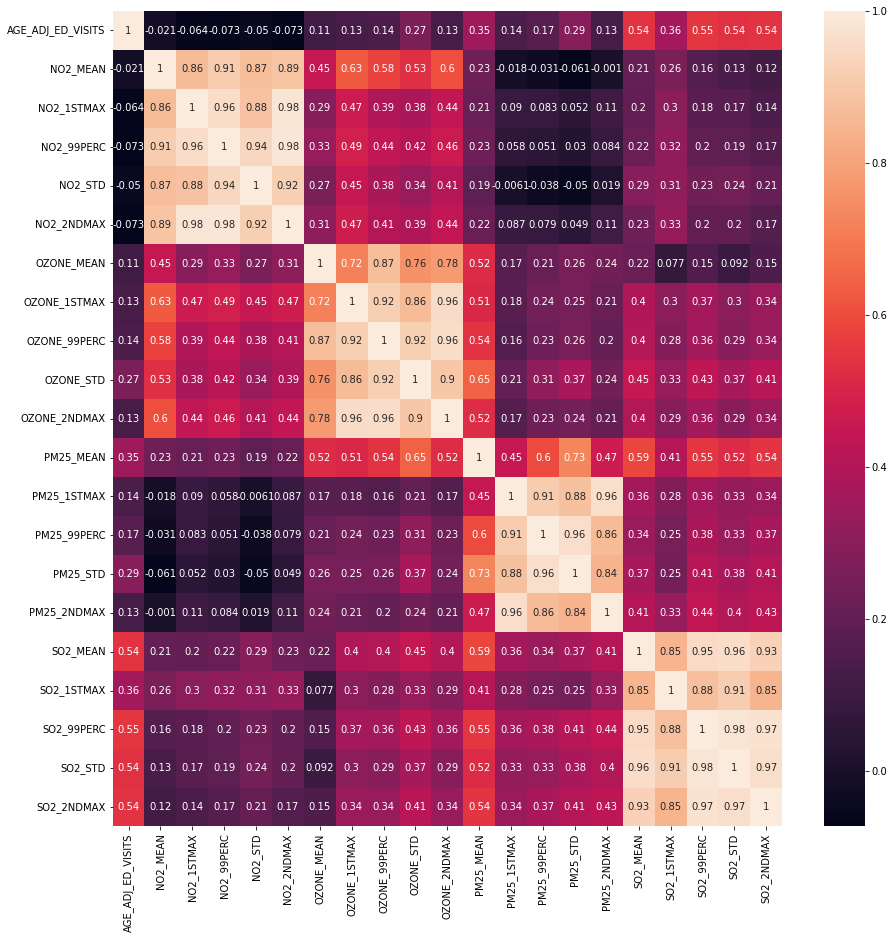

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt
## Do a correlation matrix to see how it all looks
corrMatrix = df.loc[:, ~df.columns.isin(
    ['YEAR', 'COUNTY_NAME', 'COUNTY_ID'])].corr()
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix, annot=True)

plt.show()


This shows some troubling correlations between NO2 and ozone that may indicate multi-colinearity between the two. Additionally, the NO2 correlation to the asthma rate appears very low. Because of that, remove the NO2 variables and continue.

In [16]:
# Remove NO2 columns 
params = ["NO2"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")

In [17]:
df.isnull().sum()


COUNTY_ID              0
YEAR                   0
AGE_ADJ_ED_VISITS      0
COUNTY_ID              0
YEAR                   0
OZONE_MEAN             7
OZONE_1STMAX           7
OZONE_99PERC           7
OZONE_STD              7
OZONE_2NDMAX           7
PM25_MEAN            141
PM25_1STMAX          141
PM25_99PERC          141
PM25_STD             141
PM25_2NDMAX          141
SO2_MEAN             204
SO2_1STMAX           204
SO2_99PERC           204
SO2_STD              204
SO2_2NDMAX           204
COUNTY_ID              0
COUNTY_NAME            0
dtype: int64

There are a lot of empty rows in the PM25 and SO2 columns. The data set is small already so it would be nice to be able to impute values for them and continue. Create two dataframes to compare: one that drops the empty columns and one that we impute values for missing data.

There are also some duplicate columns due to the merge operation during loading. Let's get rid of them so we can reference those columns directly.

### Create a dataframe with all of the rows with missing data dropped.

In [18]:
# # Remove any rows that still have nulls
df_dropnulls = df.dropna(axis=0, how="any", inplace=False)
df_dropnulls.drop(['YEAR', "COUNTY_NAME"],
        axis=1, inplace=True, errors="ignore") 
print(df_dropnulls.shape)


(42, 19)


C:\Users\Darrell\AppData\Local\Temp\ipykernel_96556\2730026907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropnulls.drop(['YEAR', "COUNTY_NAME"],


### Create the testing and training data sets (75% training)

In [19]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X_dropnulls = df_dropnulls.drop(['AGE_ADJ_ED_VISITS', 'COUNTY_ID'], axis=1)
y_dropnulls = df_dropnulls['AGE_ADJ_ED_VISITS']

X_train_dropnulls, X_test_dropnulls, y_train_dropnulls, y_test_dropnulls = train_test_split(
    X_dropnulls, y_dropnulls, test_size=0.25, random_state=0)



## Scaling
Some of the machine learning methods used work much better when the feature vectors are transformed to a common scale. Use the standardization scaler on the training and testing feature sets. Save the mean and variance for each column as a JSON file. When we do a predict later using the model, the input features must be scaled the same as the training set.

In [20]:
from sklearn import preprocessing

scaler_train_dropnulls = preprocessing.StandardScaler().fit(X_train_dropnulls)
X_train_scaled_dropnulls = scaler_train_dropnulls.transform(X_train_dropnulls)

ScalingDF = pd.DataFrame({'Mean': scaler_train_dropnulls.mean_, 'Var': scaler_train_dropnulls.var_})
ScalingDF.index = X_train_dropnulls.columns
print(ScalingDF)
ScalingDF.to_json('X_train_scaled_dropnulls.json')

scaler_test_dropnulls = preprocessing.StandardScaler().fit(X_test_dropnulls)
X_test_scaled_dropnulls = scaler_test_dropnulls.transform(X_test_dropnulls)



                   Mean         Var
OZONE_MEAN     0.051454    0.000029
OZONE_1STMAX   0.098054    0.000264
OZONE_99PERC   0.087932    0.000194
OZONE_STD      0.014268    0.000012
OZONE_2NDMAX   0.092468    0.000224
PM25_MEAN      9.872377    8.569195
PM25_1STMAX   45.167894  317.719487
PM25_99PERC   36.376076  236.218496
PM25_STD       6.793974    8.434931
PM25_2NDMAX   35.902126  228.307262
SO2_MEAN       0.824631    0.347979
SO2_1STMAX     5.918280   27.468734
SO2_99PERC     3.190860    6.533044
SO2_STD        0.715090    0.303435
SO2_2NDMAX     3.956452   10.166213


## AdaBoost

The AdaBoost machine learning algorithm is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html?highlight=adaboost#sklearn.ensemble.AdaBoostRegressor

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Adaboost using the dropped nulls dataframe
print("DROPPED NULLS")


ABR_dropnulls = AdaBoostRegressor(random_state=0)
params = {
    'n_estimators': [100, 500, 1000, 1500, 3000, 5000, 10000],
    'learning_rate': [.5, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.8, 2.0]
}
regr_dropnulls = GridSearchCV(
    estimator=ABR_dropnulls,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(regr_dropnulls.best_params_)



DROPPED NULLS
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 0.5, 'n_estimators': 100}


In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from joblib import dump, load

# Retrain the model using just the optimized parameters
print("DROPPED NULLS")
ABR_dropnulls = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_dropnulls.best_params_['n_estimators'], 
                                  learning_rate=regr_dropnulls.best_params_['learning_rate'])
ABR_dropnulls.fit(X_train_dropnulls, y_train_dropnulls)
scores = cross_val_score(ABR_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE = {mean_squared_error(y_train_dropnulls, ABR_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2 = {ABR_dropnulls.score(X_test_dropnulls, y_test_dropnulls)} MSE = {mean_squared_error(y_test_dropnulls, ABR_dropnulls.predict(X_test_scaled_dropnulls))}")

dump(ABR_dropnulls, r"ABR_SO2_scaled_dumpnulls.model")



DROPPED NULLS
Cross-Validation Mean Scores: 0.5793864059627645
TRAIN: R2 = -0.25282213701871403 MSE = 281.3026597135359
TEST: R2 = 0.666108352590621 MSE = 196.06665378787875


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


['ABR_SO2_scaled_dumpnulls.model']

## Support Vector Regression
This method works well to fit non-linear relationships. Tuning can be done on the type of surfaces used to fit as well as other hyper-parameters. It is recommended that SVR data be scaled. The model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

In [23]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


SVR_REG = SVR(cache_size = 1000)
params = {
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'C': [.5, .7, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5 , 6] }

regr_dropnulls = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(f"Dropped Nulls: tuned parameters = {regr_dropnulls.best_params_}")


svr_opt_dropnulls = SVR(C=regr_dropnulls.best_params_['C'], 
                        kernel=regr_dropnulls.best_params_['kernel'], 
                        degree=regr_dropnulls.best_params_['degree'],
                        gamma=regr_dropnulls.best_params_['gamma'])
svr_opt_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(svr_opt_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print("Tuned SVR Results -- Dropped Nulls")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, svr_opt_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={svr_opt_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, svr_opt_dropnulls.predict(X_test_scaled_dropnulls))}")

dump(svr_opt_dropnulls, r"svr_opt_SO2_scaled_dumpnulls.model")



Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
Dropped Nulls: tuned parameters = {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Tuned SVR Results -- Dropped Nulls
0.34025981392825
TRAIN: R2=0.8417360823670249 MSE=35.535819212759364
TEST: R2=0.6715035277066219 MSE=58.39380439955875


['svr_opt_SO2_scaled_dumpnulls.model']

## Voting Regressor
Take the pretty poor regressors that we developed above and use them together in an ensemble to improve their functionality.

In [24]:
from sklearn.ensemble import VotingRegressor

print("DROPPED NULLS")
ereg_dropnulls = VotingRegressor(
    estimators=[('ABR', ABR_dropnulls), ('svr_opt', svr_opt_dropnulls)])
ereg_dropnulls = ereg_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(ereg_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(scores.mean())

print(f"TEST: R2={ereg_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, ereg_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={ereg_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, ereg_dropnulls.predict(X_test_scaled_dropnulls))}")

dump(ereg_dropnulls, r"voting_1_SO2_scaled_dumpnulls.model")



DROPPED NULLS
0.5143970189744692
TEST: R2=0.9361339519657695 MSE=14.34017539007862
TEST: R2=0.7766449207284929 MSE=39.703783482277714


['voting_1_SO2_scaled_dumpnulls.model']

## Plot all of them together for training and test sets

D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


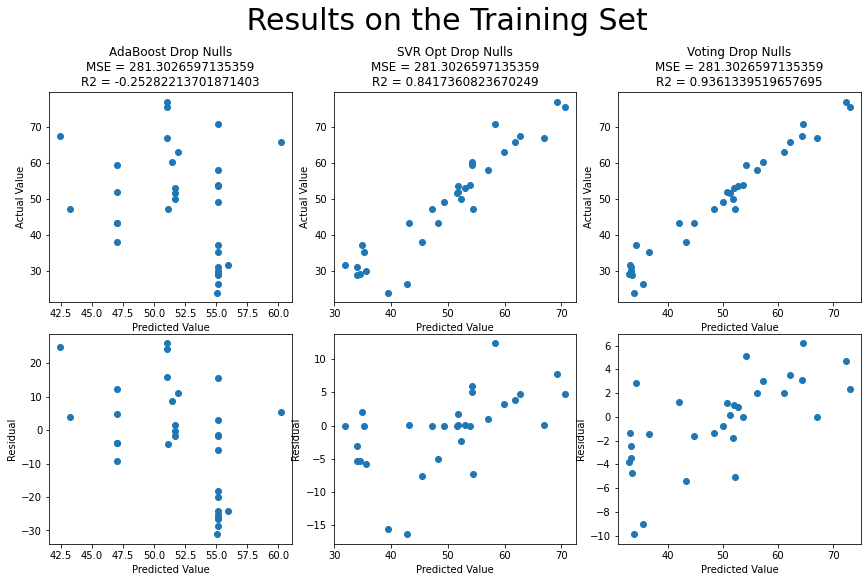

In [27]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_dropnulls = ABR_dropnulls.predict(X_train_scaled_dropnulls)
residual_ABR_dropnulls = y_train_dropnulls - predict_ABR_dropnulls
MSE_ABR_dropnulls = mean_squared_error(
    y_train_dropnulls, ABR_dropnulls.predict(X_train_scaled_dropnulls))

predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_train_scaled_dropnulls)
residual_svr_opt_dropnulls = y_train_dropnulls - predict_svr_opt_dropnulls
MSE_svr_opt_dropnulls = mean_squared_error(
    y_train_dropnulls, ABR_dropnulls.predict(X_train_scaled_dropnulls))

predict_ereg_dropnulls = ereg_dropnulls.predict(X_train_scaled_dropnulls)
residual_ereg_dropnulls = y_train_dropnulls - predict_ereg_dropnulls
MSE_ereg_dropnulls = mean_squared_error(
    y_train_dropnulls, ABR_dropnulls.predict(X_train_scaled_dropnulls))

cols = [f'AdaBoost Drop Nulls\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'SVR Opt Drop Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'Voting Drop Nulls\nMSE = {MSE_ereg_dropnulls}\nR2 = {ereg_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}']


figure, axis = plt.subplots(2, 3, figsize=(12, 8))
figure.suptitle(' Results on the Training Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_train_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_dropnulls, y_train_dropnulls)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_dropnulls, y_train_dropnulls)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_dropnulls, residual_ereg_dropnulls)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

plt.show()


D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
D:\Users\Darrell\anaconda3\envs\PowerBI2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


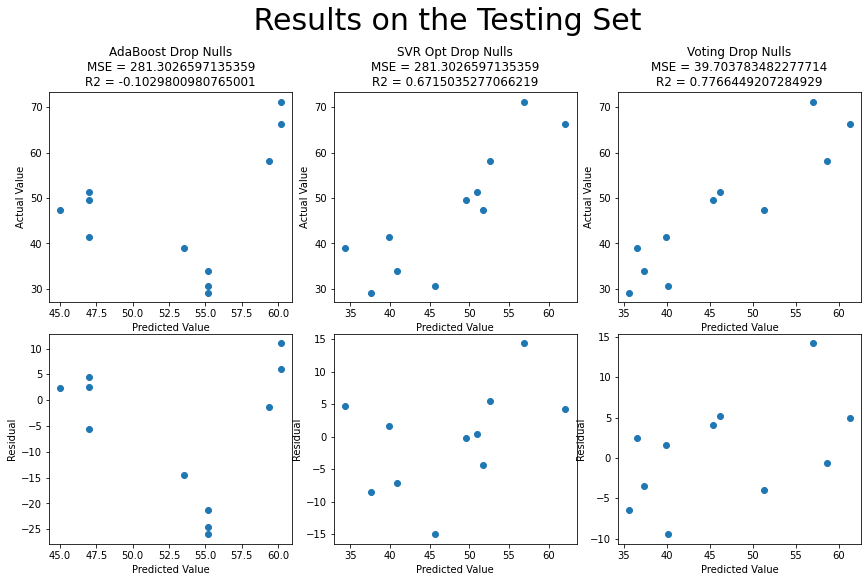

In [29]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR_dropnulls = ABR_dropnulls.predict(X_test_scaled_dropnulls)
residual_ABR_dropnulls = y_test_dropnulls - predict_ABR_dropnulls
MSE_ereg_dropnulls = mean_squared_error(
    y_test_dropnulls, ABR_dropnulls.predict(X_test_scaled_dropnulls))

predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_test_scaled_dropnulls)
residual_svr_opt_dropnulls = y_test_dropnulls - predict_svr_opt_dropnulls
MSE_ereg_dropnulls = mean_squared_error(
    y_test_dropnulls, svr_opt_dropnulls.predict(X_test_scaled_dropnulls))

predict_ereg_dropnulls = ereg_dropnulls.predict(X_test_scaled_dropnulls)
residual_ereg_dropnulls = y_test_dropnulls - predict_ereg_dropnulls
MSE_ereg_dropnulls = mean_squared_error(
    y_test_dropnulls, ereg_dropnulls.predict(X_test_scaled_dropnulls))

cols = [f'AdaBoost Drop Nulls\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}',
        f'SVR Opt Drop Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}',
        f'Voting Drop Nulls\nMSE = {MSE_ereg_dropnulls}\nR2 = {ereg_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)}']

figure, axis = plt.subplots(2, 3, figsize=(12, 8))
figure.suptitle(' Results on the Testing Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_test_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_dropnulls, y_test_dropnulls)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_ereg_dropnulls, y_test_dropnulls)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_ereg_dropnulls, residual_ereg_dropnulls)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

plt.show()
